<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/01_nice_rot_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import imutils

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [3]:

class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2), nn.ReLU()) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow, forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [4]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.20,
                                                   random_state=42)

X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

#train_data = Data(X_train)

In [5]:
list_train = []
list_y_train = []

for i in range(10):
  random = np.random.randint(0,140,30) # gives 30 integers betw. 0 and 140

  list_train.append(X_train[y_train[:]==i][random])
  list_y_train.append([y_train[y_train[:]==i][random]])



gen_train = torch.tensor(np.array(list_train)).reshape(300,64)
gen_y_train = torch.tensor(np.array(list_y_train)).reshape(300)


Text(0.5, 1.0, '9')

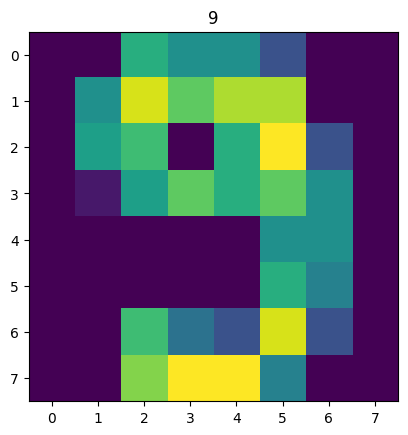

In [6]:
image=299
plt.imshow(gen_train[image].reshape(8,8))
plt.title('{}'.format(gen_y_train[image]))

In [7]:
for i in range(len(gen_train)):
  for j in [90,180,270]:
    rotated_im = imutils.rotate(gen_train[i].numpy().reshape(8,8), angle=j).reshape((1,64))
    gen_train = torch.cat((gen_train, torch.tensor(rotated_im)), 0)
    gen_y_train = torch.cat((gen_y_train, gen_y_train[i].reshape((1))), 0)

In [8]:
train_data = Data(gen_train)

Text(0.5, 1.0, '9')

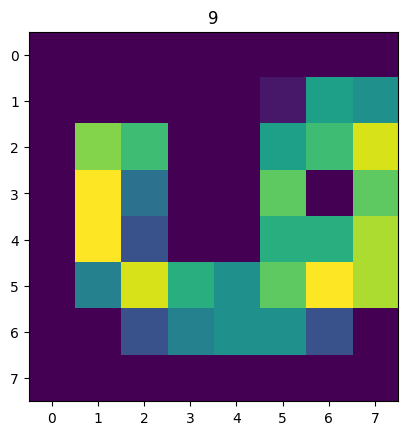

In [9]:
image=1199
plt.imshow(gen_train[image].reshape(8,8))
plt.title('{}'.format(gen_y_train[image]))

In [10]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=512, num_flows=10)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [11]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))


Epoch :  1   -----------> Loss :  91.71099548339843
Epoch :  100   -----------> Loss :  58.137175750732425
Epoch :  200   -----------> Loss :  26.220858764648437
Epoch :  300   -----------> Loss :  -4.936117362976074
Epoch :  400   -----------> Loss :  -33.469398498535156
Epoch :  500   -----------> Loss :  -60.34126663208008
Epoch :  600   -----------> Loss :  -76.60957183837891
Epoch :  700   -----------> Loss :  -89.93367919921874
Epoch :  800   -----------> Loss :  -102.38656921386719
Epoch :  900   -----------> Loss :  -101.54031982421876
Epoch :  1000   -----------> Loss :  -105.66699981689453


In [12]:
test = prior.sample((50,))
test

tensor([[ 0.1411,  0.2753, -1.5029,  ..., -2.0030,  0.9533,  0.9810],
        [ 0.6241, -0.5702,  0.5776,  ...,  0.1136, -0.7002, -0.4960],
        [ 0.9818, -1.1503, -0.3559,  ..., -0.9094,  2.0267,  0.5477],
        ...,
        [-1.8963, -0.6869, -0.1829,  ..., -1.4718,  1.4658, -1.2688],
        [ 1.2236, -1.8670, -2.0258,  ...,  0.3080,  0.0626,  0.2343],
        [-1.5156,  0.3978,  0.0595,  ..., -1.1231,  1.0982, -1.5212]])

In [13]:

sonuc = model.f_inv(test)
sonuc


tensor([[ 0.0094, -0.0343,  0.0340,  ...,  0.5422,  0.6372,  0.1059],
        [ 0.0055,  0.0256,  0.4579,  ...,  0.2334,  0.0287, -0.0404],
        [-0.0143,  0.0184, -0.0315,  ...,  0.7119,  0.1405, -0.0467],
        ...,
        [ 0.0130, -0.0328,  0.2451,  ..., -0.1084,  0.0516, -0.0181],
        [-0.0025,  0.0280,  0.0330,  ...,  0.0695,  0.0691, -0.1323],
        [ 0.0114,  0.0255,  0.0860,  ...,  0.2525, -0.0145,  0.0282]],
       grad_fn=<MulBackward0>)

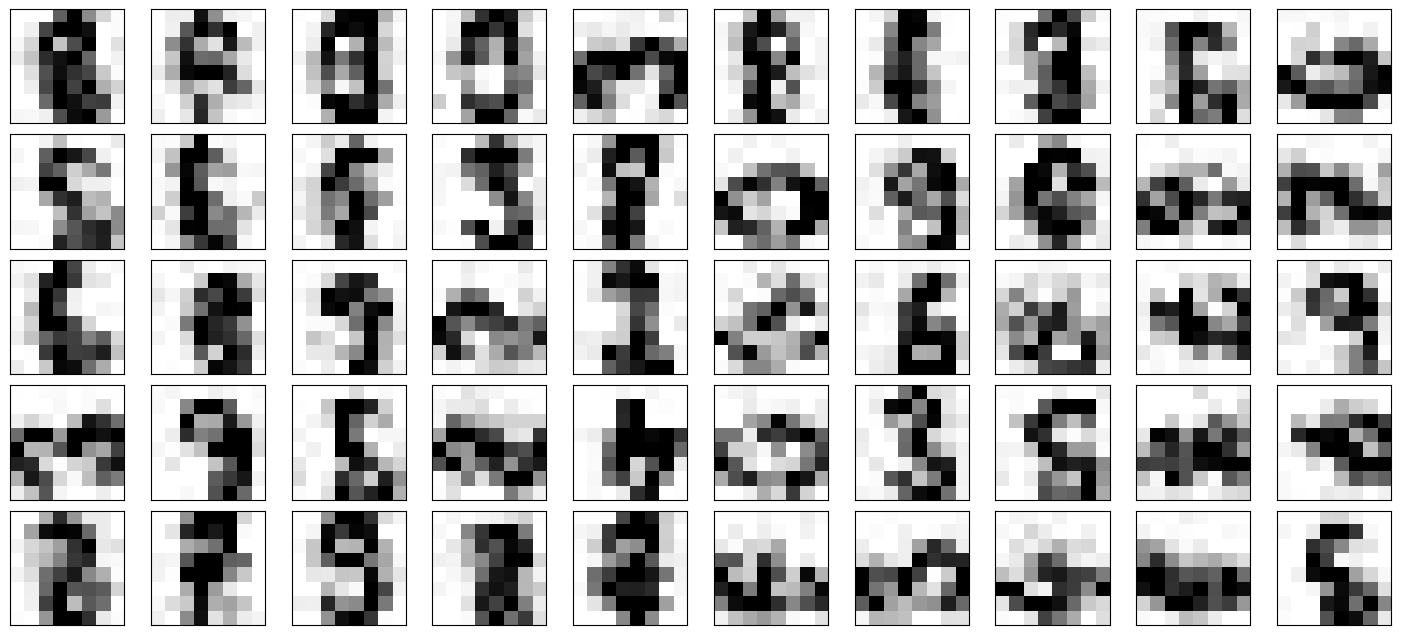

In [14]:
test = prior.sample((1797,))
sonuc = torch.nn.ReLU()(model.f_inv(test))

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
fig.show()